In [ ]:
# Cella 1: Importazione delle librerie e impostazioni (CORRETTA v2)
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle # <-- NUOVO IMPORT
# -----------------------------

sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['figure.autolayout'] = True

print("Librerie importate con successo.")

Librerie importate con successo.


In [105]:
# Cella 2: Caricamento dei dati di sintesi
summary_path = "../../data/dataset_analyzed/quantitative_summary.csv" 

try:
    summary_df = pl.read_csv(summary_path).to_pandas()
    print(f" Dati di sintesi caricati con successo da '{summary_path}'.")
    print(f"Trovate {len(summary_df)} righe di analisi.")
    
    # Visualizziamo le prime righe per un controllo
    display(summary_df.head())
    
except FileNotFoundError:
    print(f" ERRORE: File di sintesi non trovato in '{summary_path}'.")
    print("Esegui prima la pipeline 'summarize' per generare il file.")
except Exception as e:
    print(f"Si è verificato un errore durante il caricamento: {e}")

 Dati di sintesi caricati con successo da '../../data/dataset_analyzed/quantitative_summary.csv'.
Trovate 25 righe di analisi.


,repo_id,archetype,phase,num_activities,num_connections,has_review_loop,review_cycle_time_hours
0,1056253248,CollaborazioneInefficace,None,2,2,False,NaN
1,1065901806,CollaborazioneInefficace,None,2,1,False,NaN
2,1066510531,CollaborazioneInefficace,None,3,4,False,NaN
3,1066515327,CollaborazioneInefficace,None,2,2,False,NaN
4,1067234347,CollaborazioneInefficace,None,2,1,False,NaN


In [106]:
# Cella 3: Funzione helper per le annotazioni sui grafici
def show_values_on_bars(axs, h_v="v", space=0.4):
    """Aggiunge i valori numerici sopra le barre di un grafico."""
    def _show_on_single_plot(ax: Axes):
        # Itera su tutte le "patch" (forme geometriche) nel grafico
        for p in ax.patches:
            if isinstance(p, Rectangle):
                if h_v == "v":
                    _x = p.get_x() + p.get_width() / 2
                    _y = p.get_y() + p.get_height()
                    value = f"{p.get_height():.2f}"
                    ax.text(_x, _y, value, ha="center", va="bottom") 
                elif h_v == "h":
                    _x = p.get_x() + p.get_width() + float(space)
                    _y = p.get_y() + p.get_height() / 2
                    value = f"{p.get_width():.2f}"
                    ax.text(_x, _y, value, ha="left", va="center")
            # -------------------------

    if isinstance(axs, Axes):
        _show_on_single_plot(axs)
    elif hasattr(axs, '__iter__') and not isinstance(axs, str):
        for ax in axs:
            if isinstance(ax, Axes):
                _show_on_single_plot(ax)

In [107]:
# Cella 5: Preparazione dati e analisi quantitativa per Q1
q1_data = summary_df[summary_df['archetype'].isin([
    'StellaNascenteCollaborativa', 
    'CollaborazioneInefficace'
])]

if not q1_data.empty:
    # Confronto numerico diretto dei KPI medi
    q1_summary = q1_data.groupby('archetype').agg({
        'num_activities': ['mean', 'std'],
        'num_connections': ['mean', 'std'],
        'review_cycle_time_hours': ['mean', 'median', 'count']
    }).round(2)
    
    print("--- Tabella di confronto dei KPI medi ---")
    display(q1_summary)

    # Analisi adozione ciclo di review
    review_adoption = pd.crosstab(q1_data['archetype'], q1_data['has_review_loop'], normalize='index') * 100
    print("\n--- Percentuale di repository con un ciclo di review formale ---")
    display(review_adoption.round(1))
else:
    print("\n Nessun dato trovato per l'analisi Q1. Esegui la pipeline 'q1_toxic'.")

--- Tabella di confronto dei KPI medi ---


num_activities       num_connections        \
                                      mean   std            mean   std   
archetype                                                                
CollaborazioneInefficace               2.2  0.45             2.0  1.22   
StellaNascenteCollaborativa            3.2  1.10             7.0  4.85   

                            review_cycle_time_hours               
                                               mean median count  
archetype                                                         
CollaborazioneInefficace                        NaN    NaN     0  
StellaNascenteCollaborativa                    0.01   0.01     1


--- Percentuale di repository con un ciclo di review formale ---


has_review_loop,False,True
archetype,,
CollaborazioneInefficace,100.0,0.0
StellaNascenteCollaborativa,80.0,20.0


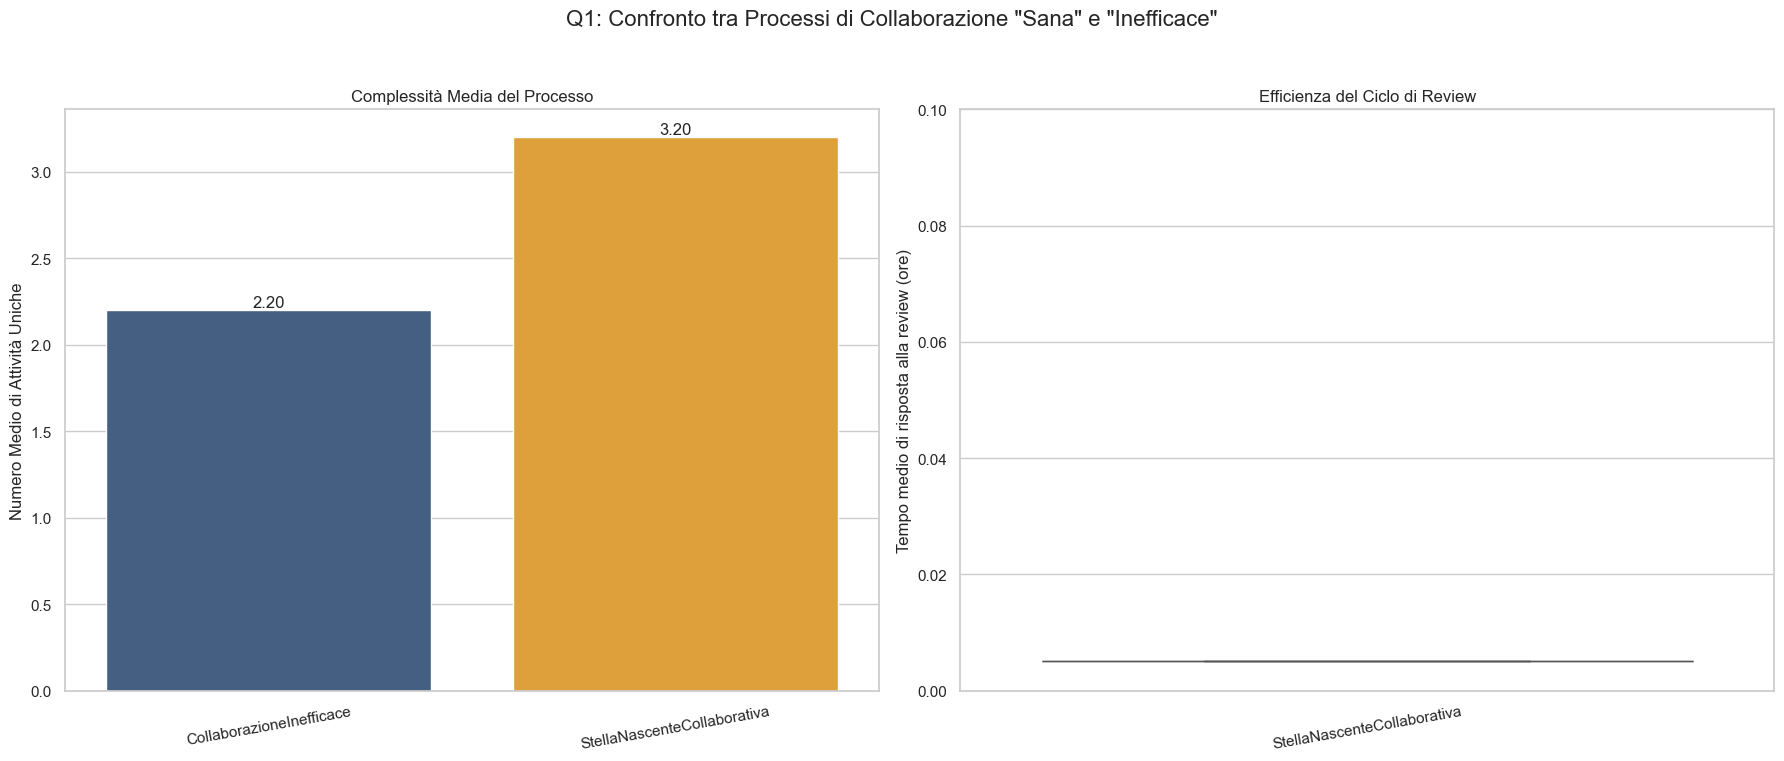

In [108]:
# Cella 6: Visualizzazioni per Q1
if not q1_data.empty:
    # Prepara i dati per il boxplot
    boxplot_data = q1_data.dropna(subset=['review_cycle_time_hours'])

    fig, axes = plt.subplots(1, 2, figsize=(18, 8), gridspec_kw={'width_ratios': [1, 1]})
    fig.suptitle('Q1: Confronto tra Processi di Collaborazione "Sana" e "Inefficace"', fontsize=16)

    # Grafico 1: Complessità del processo
    sns.barplot(
        data=q1_data, x='archetype', y='num_activities', ax=axes[0], 
        estimator='mean', errorbar=None, palette=["#3a5e8c", "#f9a620"],
        hue='archetype', legend=False
    )
    axes[0].set_title('Complessità Media del Processo')
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Numero Medio di Attività Uniche')
    axes[0].tick_params(axis='x', rotation=10)
    show_values_on_bars(axes[0])

    # Grafico 2: Efficienza della review
    if not boxplot_data.empty:
        sns.boxplot(
            data=boxplot_data, x='archetype', y='review_cycle_time_hours', ax=axes[1], 
            palette=["#f9a620"],
            hue='archetype', legend=False
        )
        axes[1].set_ylim(0, max(0.1, boxplot_data['review_cycle_time_hours'].max() * 1.1))
    else:
        axes[1].text(0.5, 0.5, 'Nessun dato sul ciclo di review disponibile', 
                     horizontalalignment='center', verticalalignment='center', 
                     transform=axes[1].transAxes, color='red', fontsize=12)

    axes[1].set_title('Efficienza del Ciclo di Review')
    axes[1].set_xlabel('')
    axes[1].set_ylabel('Tempo medio di risposta alla review (ore)')
    axes[1].tick_params(axis='x', rotation=10)
    
    plt.tight_layout(rect=(0, 0.03, 1, 0.95))
    plt.show()

In [109]:
# Cella 8: Preparazione dati e analisi quantitativa per Q2
q2_data = summary_df[summary_df['archetype'] == 'Progetto Vetrina (Hype Puro)'].dropna(subset=['phase'])

if not q2_data.empty:
    q2_summary = q2_data.groupby('phase').agg(
        avg_activities=('num_activities', 'mean'),
        review_loop_adoption_perc=('has_review_loop', lambda x: x.mean() * 100),
        median_review_time_hours=('review_cycle_time_hours', 'median')
    ).round(2)

    print("--- Tabella di confronto dei KPI Prima vs. Dopo l'Hype ---")
    display(q2_summary.reindex(['prima', 'dopo']))
else:
    print("\n Nessun dato trovato per l'analisi Q2. Esegui la pipeline 'q2_hype'.")


 Nessun dato trovato per l'analisi Q2. Esegui la pipeline 'q2_hype'.


In [110]:
# Cella 9: Visualizzazioni per Q2
if not q2_data.empty:
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle("Q2: Il Processo di Sviluppo Cambia Dopo l'Hype?", fontsize=16)

    # Grafico 1: Evoluzione della complessità
    ax1 = sns.pointplot(data=q2_data, x='phase', y='num_activities', order=['prima', 'dopo'], ax=axes[0], color="#6a2c70")
    ax1.set_title('La Complessità del Processo Aumenta?')
    ax1.set_xlabel('Fase del Progetto')
    ax1.set_ylabel('Numero Medio di Attività Uniche')

    # Grafico 2: Adozione del ciclo di review
    review_adoption_hype = q2_data.groupby('phase')['has_review_loop'].value_counts(normalize=True).unstack().fillna(0)
    review_adoption_hype.plot(kind='bar', stacked=True, ax=axes[1], rot=0, colormap="plasma")
    axes[1].set_title('Adozione di Processi Formali di Review')
    axes[1].set_xlabel('Fase del Progetto')
    axes[1].set_ylabel('Percentuale di Repository')
    axes[1].legend(title='Ha un ciclo di review?', labels=['No', 'Sì'])

    plt.tight_layout(rect=(0, 0.03, 1, 0.95))
    plt.show()

In [111]:
# Cella 11: Preparazione dati e analisi quantitativa per Q3
q3_data = summary_df[summary_df['archetype'] == 'PrimaScintillaCollaborativa']

if not q3_data.empty:
    adozione_review_q3 = q3_data['has_review_loop'].value_counts(normalize=True) * 100
    print("--- Percentuale di progetti 'Prima Scintilla' che sviluppano un ciclo di review formale ---")
    print(adozione_review_q3.round(1))
    
    review_efficiency_q3 = q3_data[q3_data['has_review_loop'] == True]['review_cycle_time_hours']
    print("\n--- Statistiche sull'efficienza di queste prime review ---")
    display(review_efficiency_q3.describe().round(2))
else:
     print("\n⚠️ Nessun dato trovato per l'analisi Q3. Esegui la pipeline 'q3_review'.")

--- Percentuale di progetti 'Prima Scintilla' che sviluppano un ciclo di review formale ---
has_review_loop
False    100.0
Name: proportion, dtype: float64

--- Statistiche sull'efficienza di queste prime review ---


count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: review_cycle_time_hours, dtype: float64

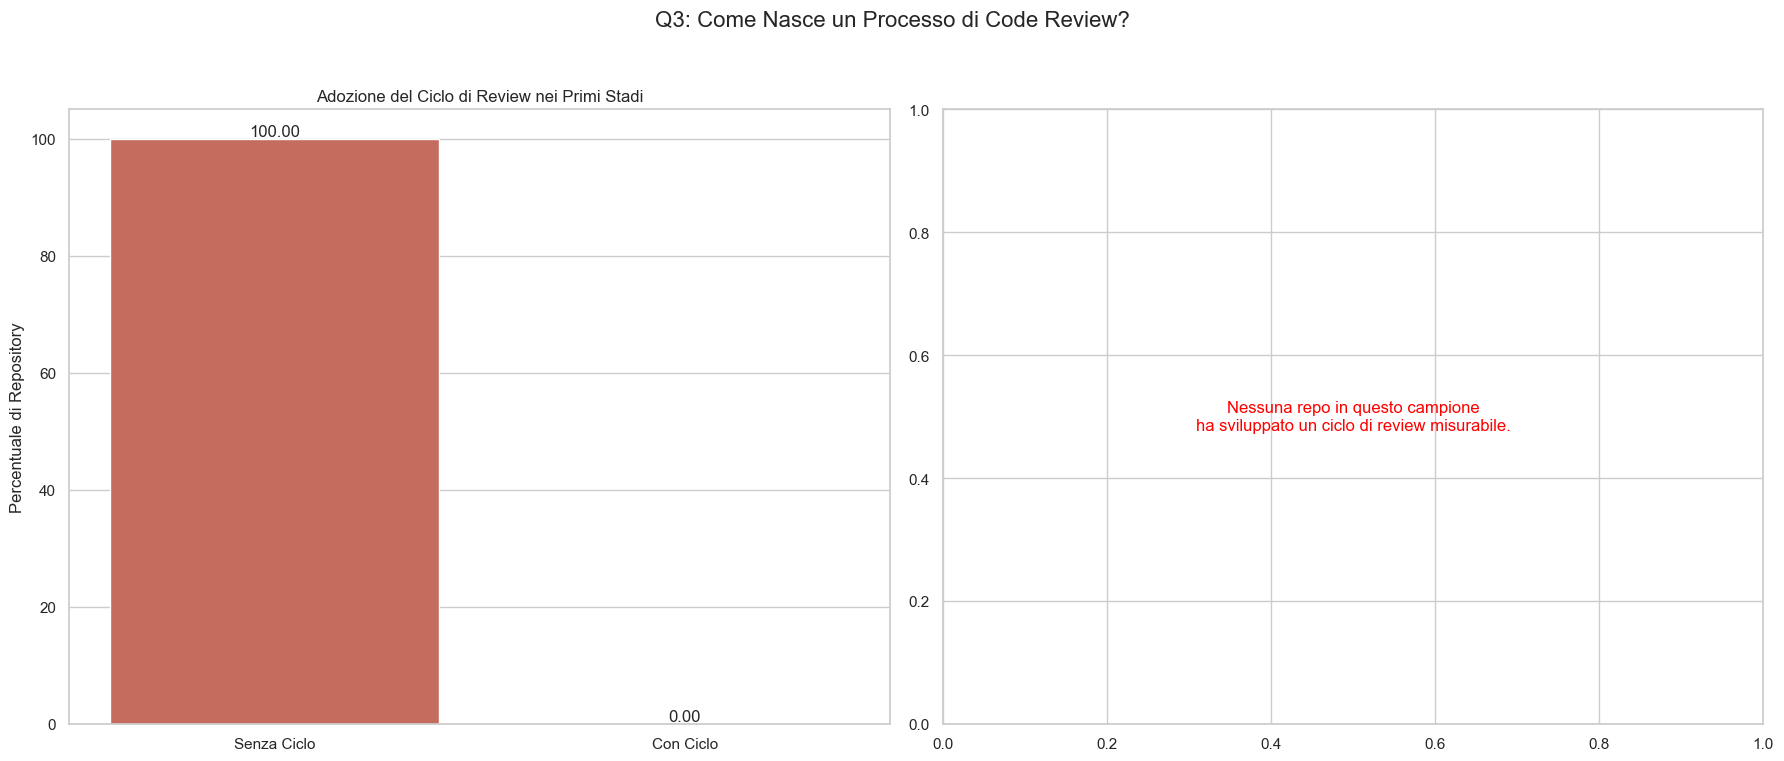

In [112]:
# Cella 12: Visualizzazioni per Q3 (Versione Robusta e Corretta)
if not q3_data.empty:
    # Calcola le proporzioni
    adozione_review_q3 = q3_data['has_review_loop'].value_counts(normalize=True) * 100

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle("Q3: Come Nasce un Processo di Code Review?", fontsize=16)

    # --- GRAFICO 1
    
    plot_data = adozione_review_q3.reindex([False, True], fill_value=0).reset_index()
    plot_data['has_review_loop'] = plot_data['has_review_loop'].map({False: 'Senza Ciclo', True: 'Con Ciclo'})

    sns.barplot(
        data=plot_data, 
        x='has_review_loop', 
        y='proportion', 
        ax=axes[0], 
        palette=["#d6604d", "#4393c3"],
        hue='has_review_loop',
        legend=False
    )
    axes[0].set_title('Adozione del Ciclo di Review nei Primi Stadi')
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Percentuale di Repository')
    axes[0].set_ylim(0, 105) # Lascia un po' di spazio in alto
    show_values_on_bars(axes[0], h_v="v", space=1) # show_values_on_bars è una tua funzione helper

    # --- GRAFICO 2 ---
    data_for_hist = q3_data[q3_data['has_review_loop'] == True]
    
    if not data_for_hist.empty:
        sns.histplot(data=data_for_hist, x='review_cycle_time_hours', kde=True, bins=15, ax=axes[1], color="#8a508f")
        axes[1].set_title('Distribuzione dei Tempi delle Prime Review')
        axes[1].set_xlabel('Tempo di Review (Ore)')
    else:
        # Questo blocco verrà eseguito, mostrando un messaggio chiaro
        axes[1].text(0.5, 0.5, 'Nessuna repo in questo campione\nha sviluppato un ciclo di review misurabile.', 
                     horizontalalignment='center', verticalalignment='center', 
                     transform=axes[1].transAxes, fontsize=12, color='red')
    
    plt.tight_layout(rect=(0, 0.03, 1, 0.95))
    plt.show()

else:
    print("Nessun dato per l'analisi Q3.")

In [113]:
# Cella 14: Spunti per l'Analisi Qualitativa
print("--- PASSO FINALE: Integrazione Qualitativa ---")
print("Usa questi dati per trovare le repository più interessanti da analizzare qualitativamente.\n")

# Assumiamo che il percorso base dell'analisi sia lo stesso del summary
analysis_base_dir = os.path.dirname(summary_path)

if not q1_data.empty:
    try:
        repo_sana_efficiente = q1_data[
            (q1_data['archetype'] == 'StellaNascenteCollaborativa') & 
            (q1_data['has_review_loop'] == True)
        ].sort_values('review_cycle_time_hours').iloc[0]
        print(f"- [Q1] La repo 'Sana' con il ciclo di review più veloce è '{repo_sana_efficiente['repo_id']}'.")
        print(f"  -> Guarda la sua 'performance_map_str.png' per capire perché è così efficiente.")
        print(f"  -> Percorso: {os.path.join(analysis_base_dir, 'process_analysis', 'Stella_Nascente_Collaborativa', str(repo_sana_efficiente['repo_id']))}\n")
    except IndexError:
        print("- [Q1] Nessuna repository 'Sana' con ciclo di review trovata per un'analisi qualitativa.\n")

if not q2_data.empty:
    try:
        # Trova repo che esistono sia prima che dopo
        repo_ids_with_both_phases = q2_data['repo_id'].value_counts()
        repo_ids_with_both_phases = repo_ids_with_both_phases[repo_ids_with_both_phases > 1].index
        
        if len(repo_ids_with_both_phases) > 0:
            repo_id_cambiata = repo_ids_with_both_phases[0]
            print(f"- [Q2] La repo '{repo_id_cambiata}' è un buon esempio di cambiamento post-hype.")
            print(f"  -> Confronta la sua 'frequency_map_prima.png' con la 'frequency_map_dopo.png' per vedere come è cambiato il workflow.")
            print(f"  -> Percorso: {os.path.join(analysis_base_dir, 'process_analysis', 'Progetto_Vetrina_Hype_Puro', str(repo_id_cambiata))}\n")
        else:
            print("- [Q2] Nessuna repository con dati sia 'prima' che 'dopo' l'hype trovata per il confronto.\n")
    except IndexError:
        print("- [Q2] Nessuna repository di hype trovata per un'analisi qualitativa.\n")

--- PASSO FINALE: Integrazione Qualitativa ---
Usa questi dati per trovare le repository più interessanti da analizzare qualitativamente.

- [Q1] La repo 'Sana' con il ciclo di review più veloce è '1055510244'.
  -> Guarda la sua 'performance_map_str.png' per capire perché è così efficiente.
  -> Percorso: ../../data/dataset_analyzed\process_analysis\Stella_Nascente_Collaborativa\1055510244

